In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,Activation,LeakyReLU,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer,MultiLabelBinarizer
from sklearn.model_selection import train_test_split


In [3]:
root_dir = r'C:\Users\Rush\Desktop\My_Notebooks\PlantVillage'
os.chdir(root_dir)
listdir()

['train', 'val']

In [4]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

data_dir = os.path.join(root_dir,'train')

"""We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above."""

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
print("Load images from all classes ...")
plant_disease_folder_list = listdir(data_dir)
print(len(plant_disease_folder_list))

Load images from all classes ...
39


In [6]:
#Loading Train and Validation Data
image_list, label_list = [], []

try:
    print("Loding Image Data ...")
    for s in listdir():
        plant_disease_folder_list = listdir(s)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"Processing  {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{data_dir}/{plant_disease_folder}/")

            for image in plant_disease_image_list[:N_IMAGES]:
                image_directory = f"{data_dir}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    print("All the images have successfully loaded!!")  
except Exception as e:
    print(f"Error : {e}")



Loding Image Data ...
Processing  Apple___Apple_scab ...
Processing  Apple___Black_rot ...
Processing  Apple___Cedar_apple_rust ...
Processing  Apple___healthy ...
Processing  background ...
Processing  Blueberry___healthy ...
Processing  Cherry_(including_sour)___healthy ...
Processing  Cherry_(including_sour)___Powdery_mildew ...
Processing  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
Processing  Corn_(maize)___Common_rust_ ...
Processing  Corn_(maize)___healthy ...
Processing  Corn_(maize)___Northern_Leaf_Blight ...
Processing  Grape___Black_rot ...
Processing  Grape___Esca_(Black_Measles) ...
Processing  Grape___healthy ...
Processing  Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
Processing  Orange___Haunglongbing_(Citrus_greening) ...
Processing  Peach___Bacterial_spot ...
Processing  Peach___healthy ...
Processing  Pepper,_bell___Bacterial_spot ...
Processing  Pepper,_bell___healthy ...
Processing  Potato___Early_blight ...
Processing  Potato___healthy ...
Processing

In [7]:
print(len(image_list))

7800


In [8]:
# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

Total number of images: 7800


# One Hot Encoding the Labels

In [9]:
"""Examine the labels/classes in the training dataset."""

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

# pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  39


In [10]:
"""# Augment and Split Dataset
Using `ImageDataGenerator` to augment data by performing various operations on the training images.
"""

augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [11]:
"""Splitting the data into training and test sets for validation purpose."""

x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
print('Successfully split data into TRAIN & TEST')

Successfully split data into TRAIN & TEST


In [12]:
"""# Build Model
Defining the hyperparameters of the plant disease classification model.
"""

EPOCHS = 10
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [13]:
"""Creating a Sequential Model to build CNN for multi-class classification"""

model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, name = 'my_dense'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 85, 85, 64)        0

# Feature Extraction from Dense Layer

In [14]:
layer_name = 'my_dense'
intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output) 
intermediate_layer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496 

In [15]:
"""# Train Model
We initialize Adam optimizer with learning rate and decay parameters. 
Also, we choose the type of loss and metrics for the model and compile it for training.
"""

# steps_per_epoch=len(x_train) // BATCH_SIZE,

# Initialize optimizer
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("Training CNN...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              epochs=10, 
                              verbose=1)
        
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Training CNN...
Epoch 1/10
195/195 [==============================] - 873s 4s/step - loss: 0.4204 - accuracy: 0.1287 - val_loss: 0.1401 - val_accuracy: 0.0513
Epoch 2/10
195/195 [==============================] - 1006s 5s/step - loss: 0.0931 - accuracy: 0.4436 - val_loss: 0.1634 - val_accuracy: 0.0846
Epoch 3/10
195/195 [==============================] - 1854s 10s/step - loss: 0.0708 - accuracy: 0.5681 - val_loss: 0.0714 - val_accuracy: 0.4622
Epoch 4/10
195/195 [==============================] - 7133s 37s/step - loss: 0.0575 - accuracy: 0.6529 - val_loss: 0.0810 - val_accuracy: 0.5071
Epoch 5/10
195/195 [==============================] - 7695s 40s/step - loss: 0.0498 - accuracy: 0.7018 - val_loss: 0.1024 - val_accuracy: 0.4494
Epoch 6/10
195/195 [==============================] - 8900s 46s/step - loss: 0.0425 - accuracy: 0.7548 - val_loss: 0.0549 - val_accuracy: 0.6558
Epoch 7/10
195/195 [==============================] - 9120s 47s/step - loss: 0.0378 - accuracy: 0.7872 - val_loss: 0.

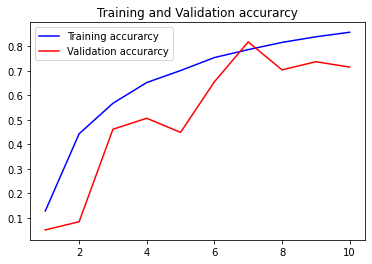

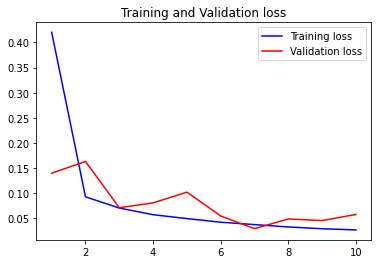

[INFO] Calculating model accuracy
49/49 [==============================] - 58s 1s/step - loss: 0.0581 - accuracy: 0.7160
Test Accuracy: 71.60256505012512


In [16]:
"""# Evaluate Model
Comparing the accuracy and loss by plotting the graph for training and validation.
"""

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

"""Evaluating model accuracy by using the `evaluate` method"""

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

In [17]:
#Saving the Model

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

#Saving intermediate layer model
#serialize the intermediate model to JSON
intermediate_layer_model_json = intermediate_layer_model.to_json()
with open("intermediate_layer_model.json", "w") as json_file:
    json_file.write(intermediate_layer_model_json)
# serialize weights to HDF5
model.save_weights("intermediate_layer_model.h5")
print("Saved intermediate_layer_model to disk")

# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
 

#model.save('PDD_completemodel')
#model.save('PDD_completemodel.h5')
#intermediate_layer_model.save('PDD_IntermediateModel')
#intermediate_layer_model.save('PDD_IntermediateModel.h5')

Saved model to disk
Saved intermediate_layer_model to disk


In [26]:
print(model_json)

{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "LeakyReLU", "config": {"name": "leaky_re_lu", "trainable": true, "dtype": "float32", "alpha": 0.10000000149011612}}, {"class_name": "BatchNormalizat

In [19]:
x_train_predict = intermediate_layer_model.predict(x_train)
# print(x_train_predict.shape)

x_test_predict = intermediate_layer_model.predict(x_test)
print(x_test_predict.shape)

MemoryError: Unable to allocate 4.57 GiB for an array with shape (6240, 256, 256, 3) and data type float32

# Support Vector Machine

In [22]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(x_train_predict,np.argmax(y_train,axis=1))

print('SVM Fit Complete')

NameError: name 'x_train_predict' is not defined

In [ ]:
svm.score(x_train_predict,np.argmax(y_train,axis=1))

In [ ]:
svm.score(x_test_predict,np.argmax(y_test,axis=1))

#Save the SVM model in pickle file
# pickle.dump(svm,open('svms.pkl', 'wb'))

In [ ]:
Pred_labels = svm.predict(x_test_predict)
Pred_labels = pd.DataFrame(Pred_labels,index =None)
Pred_labels.head()

# XGBoost Integration

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(use_label_encoder=False)

xb.fit(x_train_predict,np.argmax(y_train,axis=1))

print('XGBoost Fit Complete')

#Save XGBoost Model
# pickle.dump(xb,open('xgb_model.pkl','wb'))

In [ ]:
xb.score(x_train_predict,np.argmax(y_train,axis=1))

In [ ]:
xb.score(x_test_predict,np.argmax(y_test,axis=1))

In [ ]:
# from tensorflow.keras.models import load_model

# ai = load_model('D:\PDD_Models\HDF5\PDD_Intermediatemodel.h5')
# xgb_model = xgb.XGBClassifier()
# xgb_model.load_model(r'D:\PDD_Models\xgb_model.json')

# x2 = ai.predict(x_test)
# xgb_model.score(x_test_predict,np.argmax(y_test,axis=1))